In [1]:
#Importing libraries
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from tqdm import tqdm
import pickle

import mne
from mne.datasets import sample

# Genral Information

These are the values for the Jansen Rit Model which are available in the literature


https://mathematical-neuroscience.springeropen.com/articles/10.1186/s13408-017-0046-4/tables/1

- A 	Average excitatory synaptic gain - 3.25 mV
- B 	Average inhibitory synaptic gain 	- 22 mV
- 𝑎	 Time constant of excitatory postsynaptic potential -10 ms
- 𝑏	 Time constant of inhibitory postsynaptic potential  -20 ms
- J	Average number of synapses between the populations 	-135
- a1  Avg. no. of syn. established by principal neurons on excitatory interneurons 	- J
- a2	Avg. no. of syn. established by excitatory interneurons on principal neurons 	- 0.8 J
- a3	Avg. no. of syn. established by principal neurons on inhibitory interneurons 	- 0.25 J
- a4	Avg. no. of syn. established by inhibitory interneurons on principal neurons 	- 0.25 J
- 𝜈max	Maximum firing rate of the neural populations (max. of sigmoid fct.) - 5 s−1
- 𝑣0  Value for which 50% of the maximum firing rate is attained 	- 6 mV


Note Christian:
- 5 Hz is wrong for v_max. I don't have access to the original JR paper, but 50 Hz according to https://link.springer.com/article/10.1007/s10827-013-0493-1/tables/1 (a more reasonable value).
- The refered table do not give the valyyes for a and b but for 1/a and 1/b
-- a = 1/(0.01) = 100 Hz
-- b = 1/(0.02) = 50 Hz



### Getting data for source generation

In [2]:
# we will be using the information of the sample subject
data_path = sample.data_path()
subjects_dir = data_path / "subjects"
subject = "sample"
meg_path = data_path / "MEG" / subject

# We get an info structure from the test subject.
info = mne.io.read_info(meg_path / "sample_audvis-ave.fif")
dt = 1.0 / info["sfreq"]

# To simulate sources, we also need a source space. It can be obtained from the forward solution of the sample subject.
fwd = mne.read_forward_solution(meg_path / "sample_audvis-meg-eeg-oct-6-fwd.fif")
src = fwd["src"]

# Getting sensor covariance matrix for EEG simulation
eeg_ch_names = [ch_name for ch_name in info.ch_names if "EEG" in ch_name]


    Read a total of 4 projection items:
        PCA-v1 (1 x 102) active
        PCA-v2 (1 x 102) active
        PCA-v3 (1 x 102) active
        Average EEG reference (1 x 60) active
Reading forward solution from /Users/deepatilwani/mne_data/MNE-sample-data/MEG/sample/sample_audvis-meg-eeg-oct-6-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read MEG forward solution (7498 sources, 306 channels, free orientations)
    Desired named matrix (kind = 3523) not available
    Read EEG forward solution (7498 sources, 60 channels, free orientations)
    Forward solutions combined: MEG, EEG
    Source spaces transformed to the forward solution coordinate frame


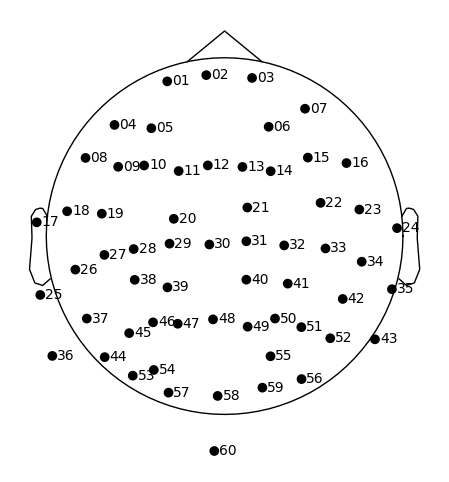

In [3]:
montage = info.get_montage()
# Get channel names and trim 'EEG:' prefix if present
channel_names = [ch.replace('EEG 0', '') for ch in montage.ch_names]

# Create a custom montage with trimmed channel names
montage.rename_channels({ch: ch.replace('EEG 0', '') for ch in montage.ch_names})

# Plot the montage with adjusted font size
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
mne.viz.plot_montage(montage, scale_factor=20, axes=ax, show_names=True)

# Adjust font size for all text elements in the plot
for text in fig.findobj(match=plt.Text):
    text.set_fontsize(12)  # Set your desired font size here

# Display the updated plot
plt.show()


fig.savefig('montage_plot.png', dpi=300, bbox_inches='tight')



### Generate stimulus

In [4]:
def generate_events(F, dt, Tbase, Ttot):
    """
    Generate the event array as expected by MNE.

    - F: Frequency of stimulus (Hz)
    - dt: Time step (s)
    - Tbase: Baseline time before stimulus starts (s)
    - Ttot: Total simulation time (s)
    
    Returns:
      - events: MNE event structure
    """
    
    event_samples = (np.arange(Tbase, Ttot, 1/F)/dt).astype(int)
    return np.array([event_samples, np.zeros_like(event_samples), np.zeros_like(event_samples)]).T


def generate_stimulus(dt, Ttot, events, pulse_width_fraction=0.05, return_time=False):
    """
    Generate the stimulation array with a pulse function.

    Parameters:
    - dt: Time step (s)
    - Ttot: Total simulation time (s)
    - events: MNE event array.
    - pulse_width_fraction: Fraction of the cycle that the pulse is high (default is 0.05)
    - return_time: Whether to return the time variable.

    Returns:
    - I: Current stimulus array
    - Ip, Ii: Modified versions of the stimulus for different inputs
    - t: (optional) time
    
    The stimulus arrays (I, Ip, Ii) are designed to drive different aspects of the simulated system, affecting different state variables.
    """
    t = np.arange(0, Ttot, dt)
    I = np.zeros_like(t)
    n_samp_stim = int(np.round(1/dt*pulse_width_fraction))
    for ind in events[:, 0]:
        I[ind:ind+n_samp_stim] = 1

    Ip = 60 * I  # Modified input for p
    Ii = 60 * 0.56 * I  # Modified input for i, using r = 0.56

    if return_time:
        return I, Ip, Ii, t
    return I, Ip, Ii        


In [14]:
F = 1  # Frequency of stimulus in Hz
#dt = 0.01  # Time step in seconds    # COR: Needs to be the same as the one used for EEG simulation which is taken from the info structure
stim_time = 60  # Duration of stimulus in seconds
Tbase = 1  # Baseline time in seconds
Ttot = 61  # Total simulation time in seconds

events = generate_events(F, dt, Tbase, Ttot)

#Run stimulus once... it will be same throughtout the experiments.
I, Ip, Ii, time = generate_stimulus(dt, Ttot, events, return_time=True)

### Run simulation

# Genral Information

These are the values for the Jansen Rit Model which are available in the literature


https://mathematical-neuroscience.springeropen.com/articles/10.1186/s13408-017-0046-4/tables/1

- A 	Average excitatory synaptic gain - 3.25 mV
- B 	Average inhibitory synaptic gain 	- 22 mV
- 𝑎	 Time constant of excitatory postsynaptic potential -10 ms
- 𝑏	 Time constant of inhibitory postsynaptic potential  -20 ms
- J	Average number of synapses between the populations 	-135
- a1  Avg. no. of syn. established by principal neurons on excitatory interneurons 	- J
- a2	Avg. no. of syn. established by excitatory interneurons on principal neurons 	- 0.8 J
- a3	Avg. no. of syn. established by principal neurons on inhibitory interneurons 	- 0.25 J
- a4	Avg. no. of syn. established by inhibitory interneurons on principal neurons 	- 0.25 J
- 𝜈max	Maximum firing rate of the neural populations (max. of sigmoid fct.) - 5 s−1
- 𝑣0  Value for which 50% of the maximum firing rate is attained 	- 6 mV


Note Christian:
- 5 Hz is wrong for v_max. I don't have access to the original JR paper, but 50 Hz according to https://link.springer.com/article/10.1007/s10827-013-0493-1/tables/1 (a more reasonable value).
- The refered table do not give the valyyes for a and b but for 1/a and 1/b
-- a = 1/(0.01) = 100 Hz
-- b = 1/(0.02) = 50 Hz



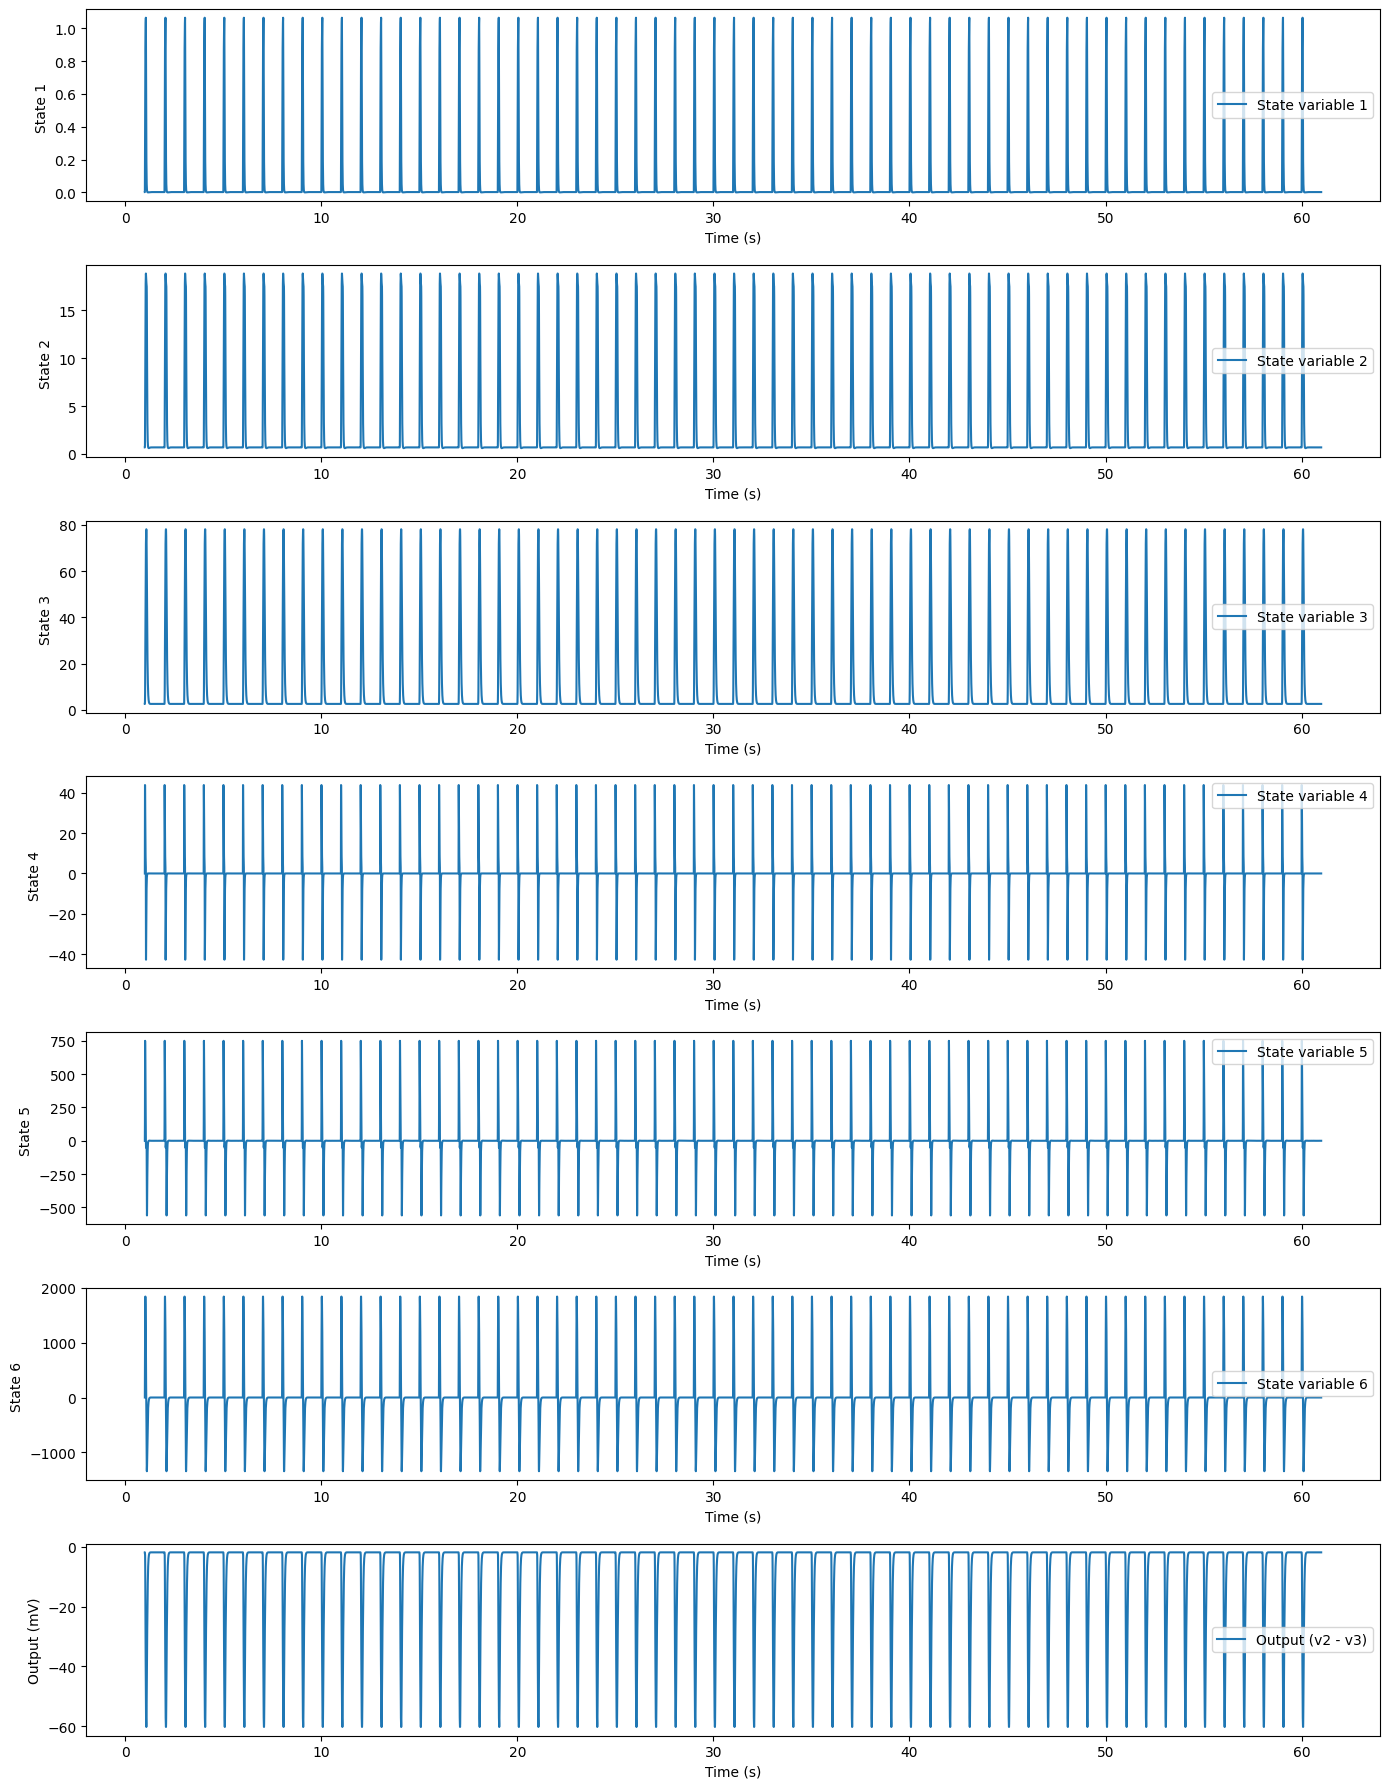

In [7]:
def run_simulation(dt, L, Ii, Ip, p, params):    # COR: Define Ip
    """
    Run the neural dynamics simulation.

    Parameters:
    - dt: Time step (s)
    - L: Length of the simulation array
    - Ii, Ip: Modified stimulus inputs
    - p: Noise term array
    - Ip, Ii: Modified versions of the stimulus for different inputs

    Returns:
    - y: Array of state variables over time

    Membrane potentials (y[0], y[1], y[2]): Typically measured in millivolts (mV).
    Derivatives (y[3], y[4], y[5]): Measured in millivolts per second (mV/s), representing the rate of change of the potentials.
    """
    y = np.zeros((6, L))
    # JR Parameters
    A = params['A1']
    B = params['B1']
    a = params['a']
    b = params['b']
    C1 = params['a_1']
    C2 = params['a2'] 
    C3 = params['a3'] 
    C4 = params['a4'] 
    v0 = 6
    r = 0.56
    ka = 1
    kA = 1
    vm = 5

    for ii in range(1, L):
        y[0, ii] = y[0, ii - 1] + dt * y[3, ii - 1]
        y[1, ii] = y[1, ii - 1] + dt * y[4, ii - 1]
        y[2, ii] = y[2, ii - 1] + dt * y[5, ii - 1]
        y[3, ii] = y[3, ii - 1] + dt * (A * a * (Ii[ii - 1] + vm / (1 + np.exp(r * (v0 - (y[1, ii - 1] - y[2, ii - 1]))))) - 2 * a * y[3, ii - 1] - a**2 * y[0, ii - 1])
        y[4, ii] = y[4, ii - 1] + dt * (kA * ka * A * a * (p[ii - 1] + Ip[ii - 1] + C2 * vm / (1 + np.exp(r * (v0 - C1 * y[0, ii - 1])))) - 2 * ka * a * y[4, ii - 1] - ka**2 * a**2 * y[1, ii - 1])
        y[5, ii] = y[5, ii - 1] + dt * (B * b * (Ip[ii - 1] + C4 * vm / (1 + np.exp(r * (v0 - C3 * y[0, ii - 1])))) - 2 * b * y[5, ii - 1] - b**2 * y[2, ii - 1])
    return y

def plot_results(time_axis, results, outputs, points_to_skip):
    """
    Plot the state variables and outputs.

    Parameters:
    - time_axis: Time axis for plotting (s)
    - results: List containing arrays of state variables
    - outputs: List containing output variable (v2 - v3)
    - points_to_skip: Number of points to skip to remove the transient
    """
    plt.figure(figsize=(14, 18))
    adjusted_time_axis = time_axis[points_to_skip:]  # Adjust time axis to skip transient

    # Iterate through each result set 
    for i, (result, output) in enumerate(zip(results, outputs)):
        # Plot each state variable in a separate subplot
        for j in range(6):
            ax = plt.subplot(7, 1, j + 1)
            ax.plot(adjusted_time_axis, result[j], label=f'State variable {j+1}')
            ax.set_xlabel('Time (s)')
            ax.set_ylabel(f'State {j+1} ')
            ax.legend()

        # Output plot on the last subplot
        ax = plt.subplot(7, 1, 7)
        ax.plot(adjusted_time_axis, output, label='Output (v2 - v3)')
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Output (mV)')
        ax.legend()

    plt.tight_layout()
    plt.show()


# Main execution

# Default Parameters from Jansen RIT model
C = 135
ground_truth = dict(
                        A1 = 3.25,
                        B1 = 22,
                        a = 100,
                        b = 50,
                        a_1 = C,
                        a2 = (0.8 * C),
                        a3 = (0.25 * C),
                        a4 = (0.25 * C)
                    )



L = len(I) #Length of the simulation array
p = 0.1 * np.random.randn(L)  # intial conditions term
y = run_simulation(dt, L, Ii, Ip, p, ground_truth)

states = []
outputs =[]


transient_duration = 1  # seconds
points_to_skip = int(transient_duration / dt)
states.append(y[:, points_to_skip:])
outputs.append((y[1] - y[2])[points_to_skip:])
time_axis = np.linspace(0, Ttot, L)
plot_results(time_axis, states, outputs, points_to_skip)


To perform inverse modeling on such signals, we would normally need to get rid of the transcient by cutting an arbitrary long segment from the start. Depending on the exact lenght we cut, the oscillatory response of the model will have a different phase-shift. If we wanted to do a Bayesian fit of these signals, we would then need to add a parameter for capturing this shift. That might be one valid way to go about it. However, DCM has previously been developped for temporal EEG response from ERP (transcient response) or EEG expectral response in the context of resting-state. These choise are probably to get around these type of issues. Lets simulate ERP.  

In [8]:

def generate_evoked_from_jr(info, src, outputs, events,tmin=-0.02, tmax=1, noise=None, noise_cov=None ): 

    #select a region to activate, we use the caudal middle frontal to grow a region of interest.
    selected_label = mne.read_labels_from_annot(
        subject, regexp="caudalmiddlefrontal-lh", subjects_dir=subjects_dir)[0]

    location = "center"  # Use the center of the region as a seed.
    extent = 10.0  # Extent in mm of the region.
    label = mne.label.select_sources(
        subject, selected_label, location=location, extent=extent, subjects_dir=subjects_dir)

    #Create simulated source activity. Here we use a SourceSimulator whose add_data method 
    #is key. It specified where (label), what (source_time_series), and when (events) an event type will occur.

    source_simulator = mne.simulation.SourceSimulator(src, tstep=dt)
    #1e-9 is for adjusting the output to uV
    source_simulator.add_data(label,  1e-9*np.array(outputs), [[0, 0, 0]])  # pass the outputs timeseries from the jansen rit herr


    #Project the source time series to sensor space and add some noise. The source simulator can be given directly to the simulate_raw function.
    raw = mne.simulation.simulate_raw(info, source_simulator, forward=fwd)

    raw.set_eeg_reference(projection=True)

    raw_clean = raw.copy()

    if noise:
        noise_cov['data'] = noise_cov.data * noise
        # Add noise using the provided noise covariance matrix X by noise factor
        mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
    else:
        # Handle invalid noise values
        print('Function failed generate_evoked_from_jr.. check the noise value')



    signal = np.mean(raw_clean.get_data()**2)
    noise = np.mean((raw.get_data() - raw_clean.get_data())**2)
    snr_db = 10*np.log10(signal/noise)

    raw.pick('eeg')

    epochs = mne.Epochs(raw, events, tmin=tmin, tmax=tmax, baseline=(None, 0))
    evoked = epochs.average()

    #del raw

    return evoked, snr_db #, raw #return raw if you want to anaylze it update the simulate_for_parameter function for returning raw


### Epoching

In [9]:


def calculate_mean_std(lo, hi):
    """Calculate mean and standard deviation from the given range."""
    mean = (hi + lo) / 2
    std = (hi - lo) / 4
    return mean, std

def sample_jansen_rit_parameters(parameter_ranges, num_samples, method=None):
    """
    Samples ground truth values for Jansen-Rit model parameters.

    Parameters:
    - parameter_ranges: dict, contains parameter names as keys and a tuple of (low, high) range as values
    - num_samples: int, number of samples to generate
    - method: str, sampling method ('linear' for linear spacing, 'normal' for normal distribution)

    Returns:
    - sampled_params: dict, contains arrays of sampled values for each parameter
    """
    sampled_params = {}
    for param, (low, high) in parameter_ranges.items():
        if method == 'linear':
            sampled_params[param] = np.linspace(low, high, num_samples)
        elif method == 'normal':
            mean = (high + low) / 2
            std = (high - low) / 4
            sampled_params[param] = np.random.normal(mean, std, num_samples)
        else:
            raise ValueError("Unknown sampling method. Use 'linear' or 'normal'.")

    return sampled_params 
  

# Post-processing and Storage

def get_evoked_xarray(evoked_results):

    evoked_array = [evoked.get_data() for evoked in evoked_results]

    # times and ch_names are consistent across all evoked objects
    if evoked_results:
        times = evoked_results[0].times
        ch_names = evoked_results[0].ch_names


    evoked_xarray = xr.DataArray(evoked_array, coords={"sim_no": range(1, len(evoked_results) + 1), "ch_names": ch_names, "time": times})    

 
    return evoked_xarray



def linear_spread_noise_fact(start, stop, num):
    return np.linspace(start, stop, num).round(2).tolist()





## EEG simulations

In [10]:



def simulate_for_parameter(parameter_ranges, L, Ii, Ip, p, dt,  C, transient_duration,
                           info, src, events,  ground_truth={}, method= None,N=None, noise=None, noise_cov=None,
                            base_path = None):
    """
    Simulates and saves results for a specific parameter range.

    :param parameter_ranges: Key for the parameter to simulate and Range tuple (low, high) for the parameter.
    :param N: Number of samples to generate.
    :param ground_truth: Dictionary of ground truth values for JR parameters.
    :param dt: Time step for the simulation.
    :param L: Length of the simulation array
    :param Ii, Ip: Modified versions of the stimulus for different inputs
    :param Ip: Pyramidal current.
    :param p: Noise term for JR
    :param C: Scaling constant for JR a_1, a2, a3, a4 parameters.
    :param transient_duration: Time to skip at the start of the simulation.
    :param info: Info object for evoked generation.
    :param src: Source space object for evoked generation.
    :param events: Events object for evoked generation.
    :param base_path: Base directory path for saving files.
    """

   
    
    # Data Preparation
    sampled_values = sample_jansen_rit_parameters(parameter_ranges, num_samples=N, method=method)

    states = []
    outputs = []
    jr_normal_params = []
    evoked_results = []
    #raw_output = []

    snr_db_output = []

    # Run the simulations
    for i in range(N):
        jr_params = ground_truth.copy()  # Start with the ground truth values
        for param in parameter_ranges.keys():
            if param in ['a1', 'a2', 'a3', 'a4']:  # Correctly check if param is in the list
                if param in sampled_values:  # Ensure param is in sampled_values before accessing it
                    jr_params[param] = C * sampled_values[param][i]
            else:
                if param in sampled_values:  # Check for existence in sampled_values before accessing
                    jr_params[param] = sampled_values[param][i]
        jr_normal_params.append(jr_params)     
        y = run_simulation(dt, L, Ii, Ip, p, jr_params)
        points_to_skip = int(transient_duration / dt)
        six_states = y[:, points_to_skip:]
        states.append(six_states)

        output = (y[1] - y[2])[points_to_skip:]
        outputs.append(output)

    # Process each output
    for output in outputs:
        # generate evoked results from the output
        evoked, snr_db = generate_evoked_from_jr(info, src, output, events, tmin=-0.2, tmax=1, noise=noise, noise_cov=noise_cov)
        evoked_results.append(evoked)
        snr_db_output.append(snr_db)
        #raw_output.append(raw_g)


    if noise:

        if '.' in str(noise):  
            # Replace '.' with '_' in this element
            noise = str(noise).replace('.', '_')
            
        
        pickle_file = f'evoked_noise_all_{N}_{noise}.pickle' #save evoked
        xarray_file = f'evoked_xarr_noise_all_{N}_{noise}.nc' #save xarray
        params_file = f'y_noise_all_{N}_{noise}.pickle' #save params
        snr_file = f'snr_noise_all_{N}_{noise}.pickle'  #save snr 
        #raw_file = f'raw_noise_{param_key}_{N}_{noise}.pickle'  #save raw

    else:
        # Save evoked object with parameter name and N in file name
        pickle_file = f'evoked_all_{N}.pickle'
        xarray_file = f'evoked_xarr_all_{N}.nc'
        params_file = f'y_all_{N}.pickle'
        snr_file = f'snr_all_{N}.pickle'
        #raw_file = f'raw_{param_key}_{N}.pickle'
        #print(jr_normal_params)


    
    #save raw
    #with open(base_path + raw_file, 'wb') as file:
     #   pickle.dump(raw_output, file, protocol=pickle.HIGHEST_PROTOCOL)     

    #save evoked  pickle   
    with open(base_path + pickle_file, 'wb') as file:
        pickle.dump(evoked_results, file, protocol=pickle.HIGHEST_PROTOCOL)

    #save snr    
    with open(base_path + snr_file, 'wb') as file:
        pickle.dump(snr_db_output, file, protocol=pickle.HIGHEST_PROTOCOL)    



    # save evoked xarray 
    evoked_xarray = get_evoked_xarray(evoked_results)
    evoked_xarray.to_netcdf(base_path + xarray_file)

    #save jr parms
    with open(base_path + params_file, 'wb') as handle:
        pickle.dump(jr_normal_params, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [68]:
#run for all parameters seprately

# update the directory here.. 
base_path='/Users/deepatilwani/Documents/Projects/DCM_withMNE/Apri13_2024/Sensitivity_Analysis/'
method = 'normal' # there is an option of 'linear' -- for linearly space sampling
N= 1000 # mention how many sampkes you want to simulate

noise_fact = [0, 0.11, 0.21, 0.32, 0.42, 0.53, 0.63, 0.74, 0.84, 0.95]


[0, 0.11, 0.21, 0.32, 0.42, 0.53, 0.63, 0.74, 0.84, 0.95]

In [69]:
parameter_ranges = {
'A1': (2.6, 9.75),
'B1': (17.6, 110.0),
'a': (5, 150),
'b': (25, 75),
'a_1': (0.5, 1.5),
'a2': (0.4, 1.2),
'a3': (0.125, 0.375),
'a4': (0.125, 0.375)
}

In [70]:
for noise in noise_fact: 
    noise_cov = mne.read_cov(meg_path / "sample_audvis-cov.fif").pick_channels(eeg_ch_names) # re-intialize coviarance matrix for every noise factor

# Simulation per parameter calling the function
    simulate_for_parameter(parameter_ranges, L, Ii, Ip, p,  dt,  C, 
                        transient_duration, info, src, events, ground_truth=ground_truth,method=method, N=N, noise=noise, noise_cov=noise_cov,
                        base_path=base_path)

    366 x 366 full covariance (kind = 1) found.
    Read a total of 4 projection items:
        PCA-v1 (1 x 102) active
        PCA-v2 (1 x 102) active
        PCA-v3 (1 x 102) active
        Average EEG reference (1 x 60) active
Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Inte

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10*np.log10(signal/noise)


    366 x 366 full covariance (kind = 1) found.
    Read a total of 4 projection items:
        PCA-v1 (1 x 102) active
        PCA-v2 (1 x 102) active
        PCA-v3 (1 x 102) active
        Average EEG reference (1 x 60) active
Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

88.95987793882307
Not setting metadata
60 matching events found
Setting baseline interval to [-0.19979521315838786, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
2 projection items activated
Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Created an SSP operator (subspace dimension = 1)
2 projection items activated
Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
2 projection items activated
Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.0

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

60 matching events found
Setting baseline interval to [-0.19979521315838786, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
2 projection items activated
Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
2 projection items activated
Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.0

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

    366 x 366 full covariance (kind = 1) found.
    Read a total of 4 projection items:
        PCA-v1 (1 x 102) active
        PCA-v2 (1 x 102) active
        PCA-v3 (1 x 102) active
        Average EEG reference (1 x 60) active
Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Created an SSP operator (subspace dimension = 1)
2 projection items activated
Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

    366 x 366 full covariance (kind = 1) found.
    Read a total of 4 projection items:
        PCA-v1 (1 x 102) active
        PCA-v2 (1 x 102) active
        PCA-v3 (1 x 102) active
        Average EEG reference (1 x 60) active
Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

46.9472841234675
Not setting metadata
60 matching events found
Setting baseline interval to [-0.19979521315838786, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
2 projection items activated
Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Created an SSP operator (subspace dimension = 1)
2 projection items activated
Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

    366 x 366 full covariance (kind = 1) found.
    Read a total of 4 projection items:
        PCA-v1 (1 x 102) active
        PCA-v2 (1 x 102) active
        PCA-v3 (1 x 102) active
        Average EEG reference (1 x 60) active
Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

    366 x 366 full covariance (kind = 1) found.
    Read a total of 4 projection items:
        PCA-v1 (1 x 102) active
        PCA-v2 (1 x 102) active
        PCA-v3 (1 x 102) active
        Average EEG reference (1 x 60) active
Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
2 projection items activated
Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.0

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

199.7793374311205
Not setting metadata
60 matching events found
Setting baseline interval to [-0.19979521315838786, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
2 projection items activated
Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
2 projection items activated
Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.0

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

2 projection items activated
Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

    366 x 366 full covariance (kind = 1) found.
    Read a total of 4 projection items:
        PCA-v1 (1 x 102) active
        PCA-v2 (1 x 102) active
        PCA-v3 (1 x 102) active
        Average EEG reference (1 x 60) active
Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

    366 x 366 full covariance (kind = 1) found.
    Read a total of 4 projection items:
        PCA-v1 (1 x 102) active
        PCA-v2 (1 x 102) active
        PCA-v3 (1 x 102) active
        Average EEG reference (1 x 60) active
Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

    366 x 366 full covariance (kind = 1) found.
    Read a total of 4 projection items:
        PCA-v1 (1 x 102) active
        PCA-v2 (1 x 102) active
        PCA-v3 (1 x 102) active
        Average EEG reference (1 x 60) active
Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

    366 x 366 full covariance (kind = 1) found.
    Read a total of 4 projection items:
        PCA-v1 (1 x 102) active
        PCA-v2 (1 x 102) active
        PCA-v3 (1 x 102) active
        Average EEG reference (1 x 60) active
Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting baseline interval to [-0.19979521315838786, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
2 projection items activated
Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interva

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    In

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interv

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
 

/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  mne.simulation.add_noise(raw, cov=noise_cov, random_state=0)
/var/folders/71/lpprjh8x2x79bf69xl_jhvy40000gn/T/ipykernel_10807/3250560002.py:41: RuntimeWarning: Projection vector 'Average EEG reference' has been reduced to 12.91% of its original magnitude by subselecting 1/60 of the original channe